# Base methods to deal with the test cases

In [19]:
import pandas as pd
from pandas import DataFrame
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(formatter={'float': '{: 0.3f}'.format})

### Base methods to deal with preprocessing data
- **fill_gaps** : *Method that deals with missing data from a dataframe*
- **normalize** : *Method that normalize data rescaling numerical values to a predefined range*
- **pca** : *Method that applies pca in a dataframe*

In [28]:
def fill_gaps(df, empty_token = '?'):
    imputer = SimpleImputer(missing_values = empty_token, strategy = 'most_frequent')
    result = imputer.fit_transform(df)
    
    result_df = DataFrame(result)
    result_df.columns = df.columns
    result_df.index = df.index
    return result_df

def normalize(df, columns, range=(0,1)):
    scaler = MinMaxScaler(feature_range=range)
    for col in columns:
        scaled_values = scaler.fit_transform(df[[col]].values.astype(float))
        df[col] = scaled_values
    return df

def pca(df, components = 70):
    pca = PCA(n_components = components)
    pca_values = pca.fit_transform(df)
    component_cols = []
    for i in range(0, components):
        component_cols.append('component_%s'%i)
    return DataFrame(data = pca_values, columns = component_cols)

def cost(fp, fn):
    return (fp * 10) + (fn * 500)

def train_classifier(pre_train_df, pre_test_df):
    x_train = pre_train_df.iloc[:, 1:].values
    y_train = pre_train_df['class'].values

    x_test = pre_test_df.iloc[:, 1:].values
    y_test = pre_test_df['class'].values

    t1_classifier = DecisionTreeClassifier()
    t1_classifier.fit(x_train, y_train)

    y_pred = t1_classifier.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    display("Accuracy %s" % (accuracy))
    tn, fp, fn, tp = confusion_matrix(y_pred, y_test).ravel()
    display ("False positives: %s - False Negatives %s" % (fp, fn))
    display("Cost: %s" % (cost(fp, fn)))
    

# Load the train and test datasets

In [29]:
train_df = pd.read_csv("aps_training_set_sample3.csv")
test_df = pd.read_csv("aps_failure_test_set.csv")

# Balancing classes in train dataset

neg    2091
pos    1000
Name: class, dtype: int64

pandas.core.series.Series

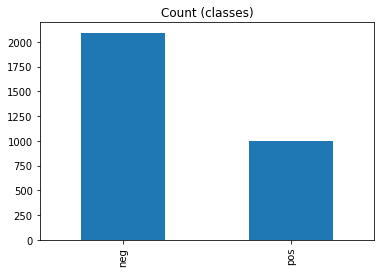

In [30]:
classes = train_df['class'].value_counts()
display(classes)
display(type(classes))
classes.plot(kind='bar', title='Count (classes)')

'Positive samples: 1000 - Negative samples: 1000'

'Using 1000 samples per class'

pos    1000
neg    1000
Name: class, dtype: int64

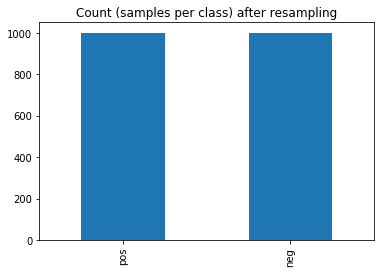

In [35]:
# we need to balance the classes 
positive_class = train_df[train_df['class'] == 'pos']
qtd_pos = positive_class.shape[0]
negative_class = train_df[train_df['class'] == 'neg']
qtd_neg = negative_class.shape[0]

display("Positive samples: %s - Negative samples: %s" %(qtd_pos, qtd_neg))
new_samples = min(qtd_neg, qtd_pos)
display("Using %s samples per class" % (new_samples))

balanced_train_df = pd.concat([positive_class[:new_samples], negative_class[:new_samples]], ignore_index = True)

balanced_classes = train_df['class'].value_counts()
display(balanced_classes)

display(balanced_classes.plot(kind='bar', title='Count (samples per class) after resampling'))

# Test Case 1
- fill_gaps
- Using DecisionTreeClassifier from sklearn

In [37]:
pre_train_df = fill_gaps(balanced_train_df)
pre_test_df = fill_gaps(test_df)
train_classifier(pre_train_df, pre_test_df)

'Accuracy 0.92725'

'False positives: 19 - False Negatives 1145'

'Cost: 572690'

# Test Case 2
- introducing normalization

In [38]:
norm_train_df = normalize(pre_train_df, columns = pre_train_df.columns[1:]) # ignore label
norm_test_df = normalize(pre_test_df, columns = pre_test_df.columns[1:]) # ignore label
train_classifier(norm_train_df, norm_test_df)

'Accuracy 0.938875'

'False positives: 130 - False Negatives 848'

'Cost: 425300'

# Test Case 3

In [46]:
pca_train_df = pca(pre_train_df.loc[:, pre_train_df.columns != 'class'])
pca_test_df = pca(pre_test_df.loc[:, pre_train_df.columns != 'class'])

pca_train_df = pd.concat([pre_train_df['class'], pca_train_df], axis=1)
pca_test_df = pd.concat([pre_test_df['class'], pca_test_df], axis = 1)
train_classifier(pca_train_df, pca_test_df)


'Accuracy 0.5148125'

'False positives: 36 - False Negatives 7727'

'Cost: 3863860'